In [12]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.tsa.adfvalues import mackinnonp
from statsmodels.tsa.vector_ar.vecm import coint_johansen, select_order
from statsmodels.tsa.vector_ar.var_model import VAR
from statsmodels.tsa.stattools import adfuller

In [8]:
import os
os.chdir('D:\\R Studio')

In [9]:
df = pd.read_excel('pinksheet.xlsx', sheet_name="Monthly Prices", skiprows=6)

In [13]:
df.rename(columns={df.columns[0]: 'Date'}, inplace=True)

In [14]:
df['Date'] = pd.to_datetime(df['Date'].apply(lambda x: f"{x[:4]}-{x[5:]}-01"))

In [15]:
commodity = df.iloc[:, [0, 2, 24, 69, 71, 60, 30]].copy()

In [16]:
commodity_data = commodity.drop(columns=['Date'])

In [17]:
# Initialize counters and lists for stationary and non-stationary columns
non_stationary_count = 0
stationary_columns = []
non_stationary_columns = []

In [25]:
# Loop through each column and perform the ADF test
for col in commodity_data.columns:
    adf_result = adfuller(commodity_data[col], autolag='AIC')
    p_value = adf_result[1]
    print(f"\nADF test result for column: {col}\n")
    print(f"ADF Statistic: {adf_result[0]}")
    print(f"p-value: {p_value}")
    print(f"Critical Values: {adf_result[4]}")


ADF test result for column: CRUDE_BRENT

ADF Statistic: -1.5078661910935343
p-value: 0.5296165197702398
Critical Values: {'1%': -3.439006442437876, '5%': -2.865360521688131, '10%': -2.5688044403756587}

ADF test result for column: SOYBEANS

ADF Statistic: -2.4231464527418902
p-value: 0.1353097742779038
Critical Values: {'1%': -3.4388599939707056, '5%': -2.865295977855759, '10%': -2.5687700561872413}

ADF test result for column: GOLD

ADF Statistic: 1.3430517021933006
p-value: 0.9968394353612382
Critical Values: {'1%': -3.4389608473398194, '5%': -2.8653404270188476, '10%': -2.568793735369693}

ADF test result for column: SILVER

ADF Statistic: -1.397294710746222
p-value: 0.5835723787985764
Critical Values: {'1%': -3.438915730045254, '5%': -2.8653205426302253, '10%': -2.5687831424305845}

ADF test result for column: UREA_EE_BULK

ADF Statistic: -2.5101716315209086
p-value: 0.11301903181624645
Critical Values: {'1%': -3.439006442437876, '5%': -2.865360521688131, '10%': -2.568804440375658

In [27]:
# Check if the p-value is greater than 0.05 (commonly used threshold)
if p_value > 0.05:
        non_stationary_count += 1
        non_stationary_columns.append(col)
else:
    stationary_columns.append(col)

In [28]:
# Print the number of non-stationary columns and the lists of stationary and non-stationary columns
print(f"\nNumber of non-stationary columns: {non_stationary_count}")
print(f"Non-stationary columns: {non_stationary_columns}")
print(f"Stationary columns: {stationary_columns}")


Number of non-stationary columns: 1
Non-stationary columns: ['MAIZE']
Stationary columns: []


In [29]:
# Co-Integration Test (Johansen's Test)
# Determining the number of lags to use (you can use information criteria like AIC, BIC)
lags = select_order(commodity_data, maxlags=10, deterministic='co')
lag_length = lags.aic

In [30]:
vecm_model = coint_johansen(commodity_data, det_order=0, k_ar_diff=lag_length)

In [31]:
# Summary of the Co-Integration Test
print(f"Eigenvalues:\n{vecm_model.eig}")
print(f"Eigenvectors:\n{vecm_model.evec}")
print(f"Critical values (90%, 95%, 99%):\n{vecm_model.cvt}")
print(f"Test statistics:\n{vecm_model.lr1}")

Eigenvalues:
[0.09431985 0.06196904 0.04110116 0.02789953 0.01418223 0.00736032]
Eigenvectors:
[[ 2.12827727e-02  2.83145324e-02 -4.99462462e-02 -5.79651587e-02
   3.34803501e-02  3.84476628e-02]
 [ 1.96223886e-02  1.67204032e-02  2.92349459e-03  2.67452105e-02
   1.99277663e-03  4.64057768e-03]
 [ 3.79130615e-04  9.37065849e-04 -7.93993119e-04 -3.11366270e-03
  -2.35406169e-04 -5.05402179e-03]
 [-1.08143764e-01 -2.74469966e-02  4.31862630e-01  1.04264015e-01
   1.92259858e-02  1.62436624e-01]
 [-2.16182231e-02  7.76919046e-03  3.34315613e-03  3.30290644e-03
  -4.78610536e-03 -1.32821122e-03]
 [-5.50526567e-03 -6.90390366e-02 -3.42282470e-02 -2.07599286e-02
   3.99227776e-03 -8.10054824e-03]]
Critical values (90%, 95%, 99%):
[[ 91.109   95.7542 104.9637]
 [ 65.8202  69.8189  77.8202]
 [ 44.4929  47.8545  54.6815]
 [ 27.0669  29.7961  35.4628]
 [ 13.4294  15.4943  19.9349]
 [  2.7055   3.8415   6.6349]]
Test statistics:
[194.54858991 118.95889314  70.1480132   38.12513847  16.53520264
 

In [32]:
# Determine the number of co-integrating relationships (r) based on the test
# Here, we assume r = 1 if there's at least one significant eigenvalue
r = 1  # Replace with the actual number from the test results

VECM Coefficients:
 [[ 0.02128277]
 [ 0.01962239]
 [ 0.00037913]
 [-0.10814376]
 [-0.02161822]
 [-0.00550527]]


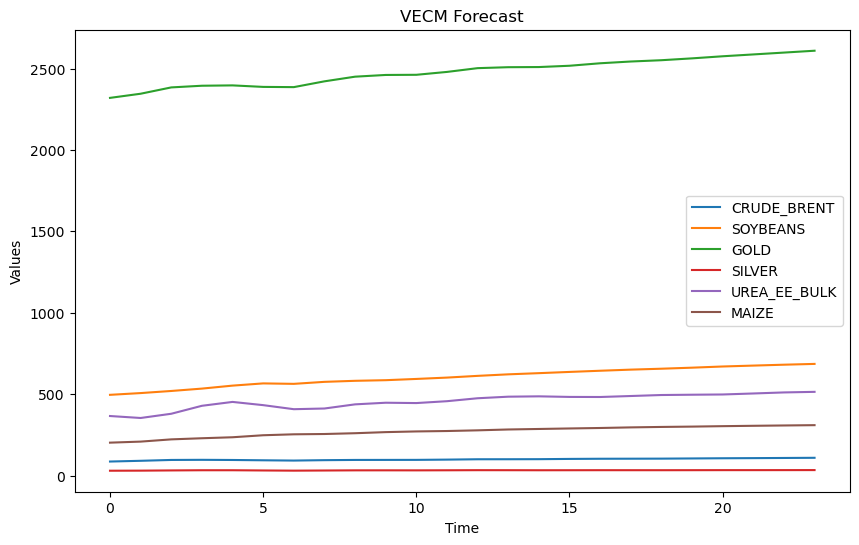

In [47]:
if r > 0:
    # If co-integration exists, estimate the VECM model
    vecm_coefs = vecm_model.evec[:, :r]
    print("VECM Coefficients:\n", vecm_coefs)

    # Creating a VAR model for prediction using the VECM
    var_model = VAR(commodity_data)
    var_results = var_model.fit(lag_length)
    
    # Forecasting using the VAR model
    forecast = var_results.forecast(commodity_data.values[-lag_length:], steps=24)
    
    # Plotting the forecast
    plt.figure(figsize=(10, 6))
    plt.plot(forecast)
    plt.title('VECM Forecast')
    plt.xlabel('Time')
    plt.ylabel('Values')
    plt.legend(commodity_data.columns)
    plt.show()
    
else:
    # If no co-integration exists, proceed with Unrestricted VAR Analysis
    var_model = VAR(commodity_data)
    var_results = var_model.fit(lag_length)

In [49]:
 # Summary of the VAR model
print(var_results.summary())

  Summary of Regression Results   
Model:                         VAR
Method:                        OLS
Date:           Thu, 25, Jul, 2024
Time:                     19:06:15
--------------------------------------------------------------------
No. of Equations:         6.00000    BIC:                    27.5091
Nobs:                     764.000    HQIC:                   26.1424
Log likelihood:          -15798.0    FPE:                9.61323e+10
AIC:                      25.2869    Det(Omega_mle):     6.06325e+10
--------------------------------------------------------------------
Results for equation CRUDE_BRENT
                      coefficient       std. error           t-stat            prob
-----------------------------------------------------------------------------------
const                   -0.511081         0.492153           -1.038           0.299
L1.CRUDE_BRENT           1.286720         0.039968           32.194           0.000
L1.SOYBEANS              0.009139         

In [55]:
# Granger causality test
# Note: Replace 'dependent_var' and 'independent_var' with actual column names
causality_results = var_results.test_causality
print(causality_results)

<bound method VARResults.test_causality of <statsmodels.tsa.vector_ar.var_model.VARResults object at 0x00000202B63E3650>>


In [57]:
# Forecasting using the VAR model
forecast = var_results.forecast(commodity_data.values[-lag_length:], steps=24)

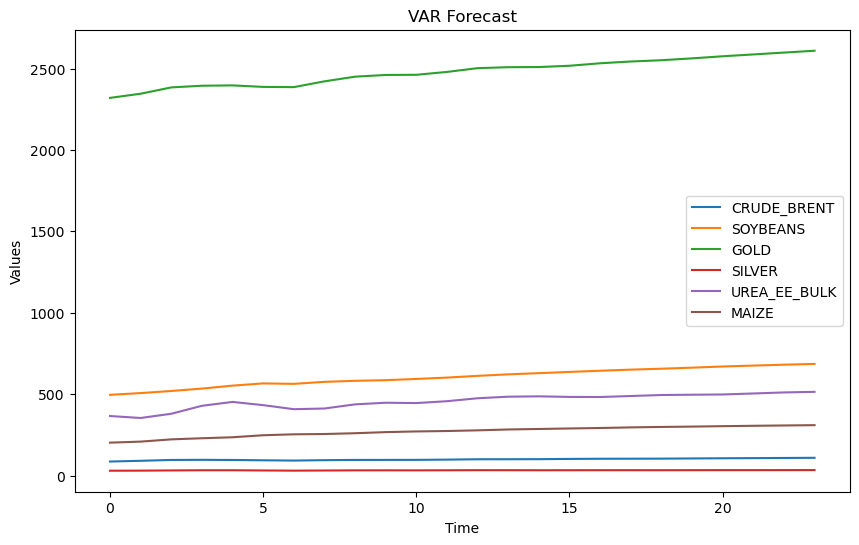

array([[  85.91762827,  495.67905179, 2319.8108355 ,   29.49151698,
         365.5165927 ,  201.93061203],
       [  90.44776345,  506.45488961, 2345.29708704,   29.95253173,
         353.43826877,  208.3255907 ],
       [  95.66038428,  519.38034599, 2384.15095934,   31.30299808,
         379.42689949,  222.08132556],
       [  96.43973899,  533.92130494, 2394.40072214,   32.419048  ,
         428.32121932,  228.97214718],
       [  95.46875966,  552.2424112 , 2396.54540874,   32.41619694,
         452.13154495,  235.07571751],
       [  93.57266199,  565.88265035, 2387.25199185,   31.05866169,
         432.34645772,  247.40034428],
       [  91.85084996,  563.13154902, 2385.84141652,   29.91495553,
         407.42921951,  253.1632003 ],
       [  94.33490806,  575.39462001, 2421.44991929,   30.83231913,
         411.6712742 ,  255.01040739],
       [  95.72959328,  581.81044915, 2450.04764763,   31.81138777,
         437.14485878,  259.86954476],
       [  95.92424971,  585.62121907,

In [58]:
# Plotting the forecast
plt.figure(figsize=(10, 6))
plt.plot(forecast)
plt.title('VAR Forecast')
plt.xlabel('Time')
plt.ylabel('Values')
plt.legend(commodity_data.columns)
plt.show()

forecast